In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import os, cv2, json
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

In [2]:
directory = '../input/cassava-leaf-disease-classification'
os.listdir(directory)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

## Data

In [3]:
print('Number of train images: ', len(os.listdir(os.path.join(directory, 'train_images'))))
print('Number of test images: ', len(os.listdir(os.path.join(directory, 'test_images'))))

Number of train images:  21397
Number of test images:  1


In [4]:
with open(os.path.join(directory, 'label_num_to_disease_map.json')) as file:
    print(json.dumps(json.loads(file.read()), indent = 4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [5]:
train_labels = pd.read_csv(os.path.join(directory, 'train.csv'))
train_labels.head(10)

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
5  1000837476.jpg      3
6  1000910826.jpg      2
7  1001320321.jpg      0
8  1001723730.jpg      4
9  1001742395.jpg      3

In [6]:
train_labels['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

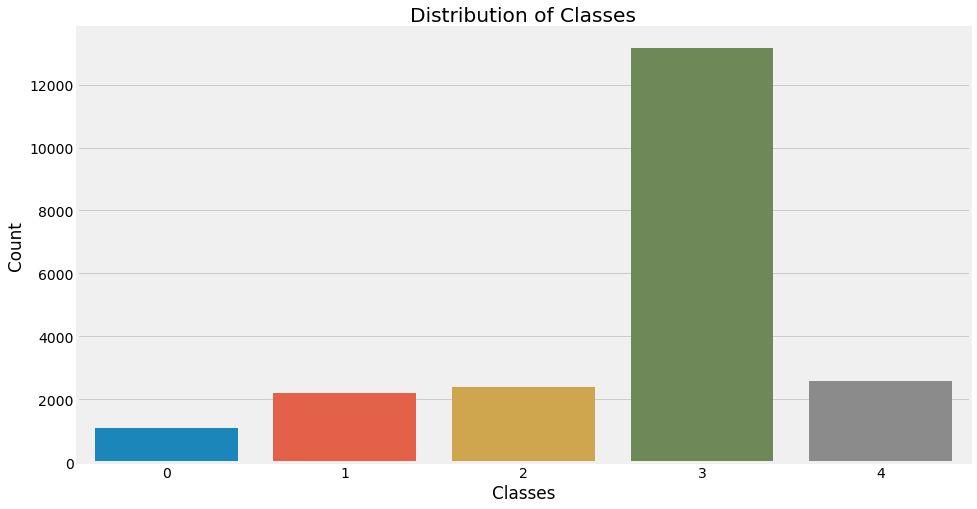

In [7]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')

sns.countplot(train_labels['label'])
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')

plt.show()

## Class 0: Cassava Bacterial Blight (CBB)

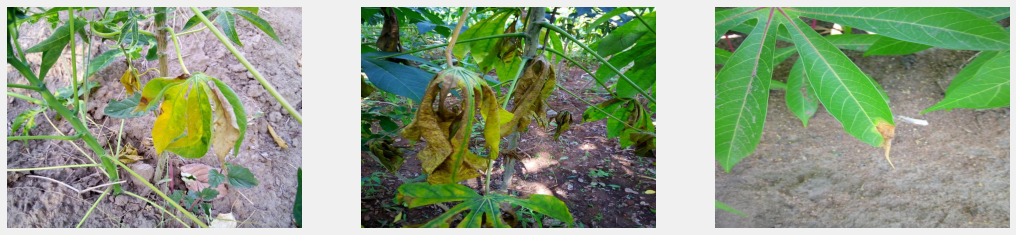

In [8]:
sample = train_labels[train_labels.label == 0].sample(3)
plt.figure(figsize = (16, 8))

for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(directory, 'train_images', image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

## Class 1: Cassava Brown Streak Disease (CBSD)

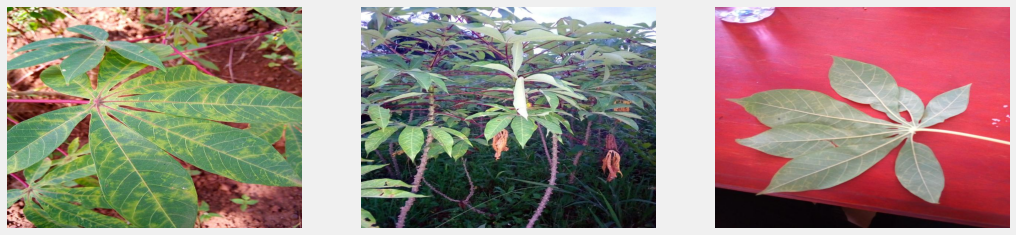

In [9]:
sample = train_labels[train_labels.label == 1].sample(3)
plt.figure(figsize = (16, 8))

for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(directory, 'train_images', image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

## Class 2: Cassava Green Mottle (CGM)

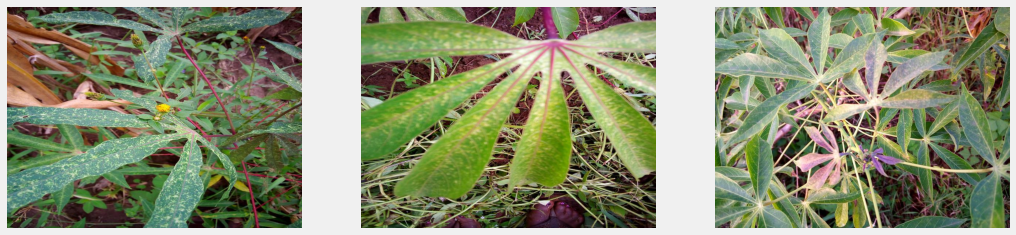

In [10]:
sample = train_labels[train_labels.label == 2].sample(3)
plt.figure(figsize = (16, 8))

for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(directory, 'train_images', image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

## Class 3: Cassava Mosaic Disease (CMD)

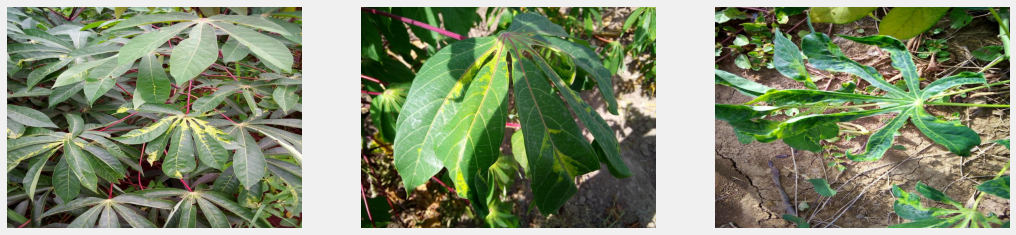

In [11]:
sample = train_labels[train_labels.label == 3].sample(3)
plt.figure(figsize = (16, 8))

for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(directory, 'train_images', image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

## Class 4: Healthy

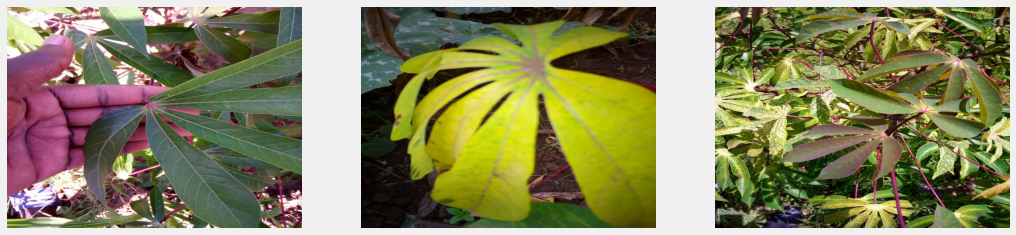

In [12]:
sample = train_labels[train_labels.label == 4].sample(3)
plt.figure(figsize = (16, 8))

for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(directory, 'train_images', image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

## Modeling Preparation

In [13]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train_labels) * 0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels) * 0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 512

In [14]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(directory, 'train_images'),
                         subset = 'training',
                         x_col = 'image_id',
                         y_col = 'label',
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = 'sparse')


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(directory, 'train_images'),
                         subset = 'validation',
                         x_col = 'image_id',
                         y_col = 'label',
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = 'sparse')

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


## Before Augmentation

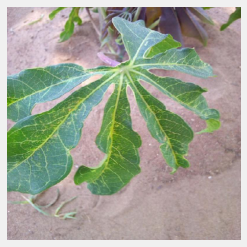

In [15]:
img_path = os.path.join(directory, 'train_images', train_labels.image_id[25])
img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

## After Augmentation

Found 1 validated image filenames belonging to 1 classes.


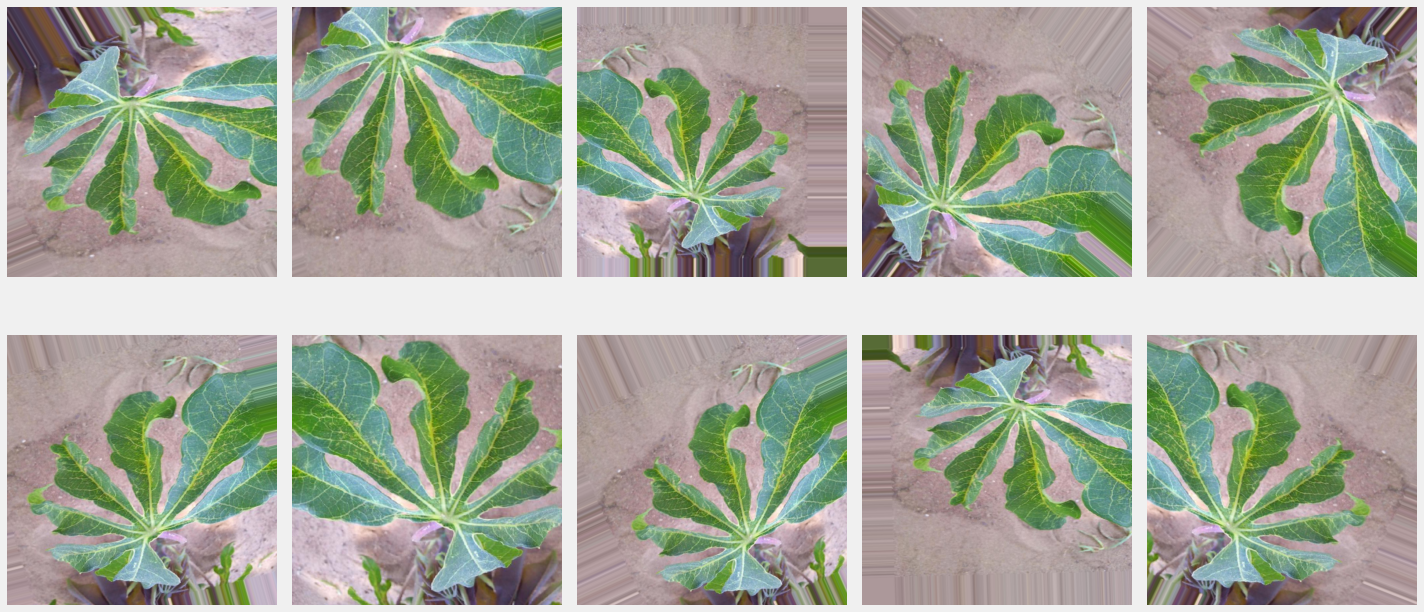

In [16]:
generator = train_datagen.flow_from_dataframe(train_labels.iloc[25:26],
                         directory = os.path.join(directory, 'train_images'),
                         x_col = 'image_id',
                         y_col = 'label',
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = 'sparse')

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()

for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Modeling using EfficientNetB0

In [17]:
def create_model():
    conv_base = EfficientNetB0(include_top = False, weights = None,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = 'softmax')(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['acc'])
    return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [18]:
print('No. of layers in EfficientNetB0:', len(model.layers))

No. of layers in EfficientNetB0: 239


In [19]:
model.load_weights('../input/model-training/basic_EffNetB0_imagenet_512.h5')

In [20]:
model_save = ModelCheckpoint('./EffNetB0_512_16_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20
1069/1069 [==============================] - 1441s 1s/step - loss: 0.6593 - acc: 0.7643 - val_loss: 0.5343 - val_acc: 0.8189

Epoch 00001: val_loss improved from inf to 0.53432, saving model to ./EffNetB0_512_16_best_weights.h5
Epoch 2/20
1069/1069 [==============================] - 1345s 1s/step - loss: 0.4722 - acc: 0.8386 - val_loss: 0.4396 - val_acc: 0.8563

Epoch 00002: val_loss improved from 0.53432 to 0.43959, saving model to ./EffNetB0_512_16_best_weights.h5
Epoch 3/20
1069/1069 [==============================] - 1342s 1s/step - loss: 0.4555 - acc: 0.8471 - val_loss: 0.4680 - val_acc: 0.8455

Epoch 00003: val_loss did not improve from 0.43959
Epoch 4/20
1069/1069 [==============================] - 1358s 1s/step - loss: 0.4402 - acc: 0.8503 - val_loss: 0.5011 - val_acc: 0.8224

Epoch 00004: val_loss did not improve from 0.43959

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/20
1069/1069 [==============================] - 1364s

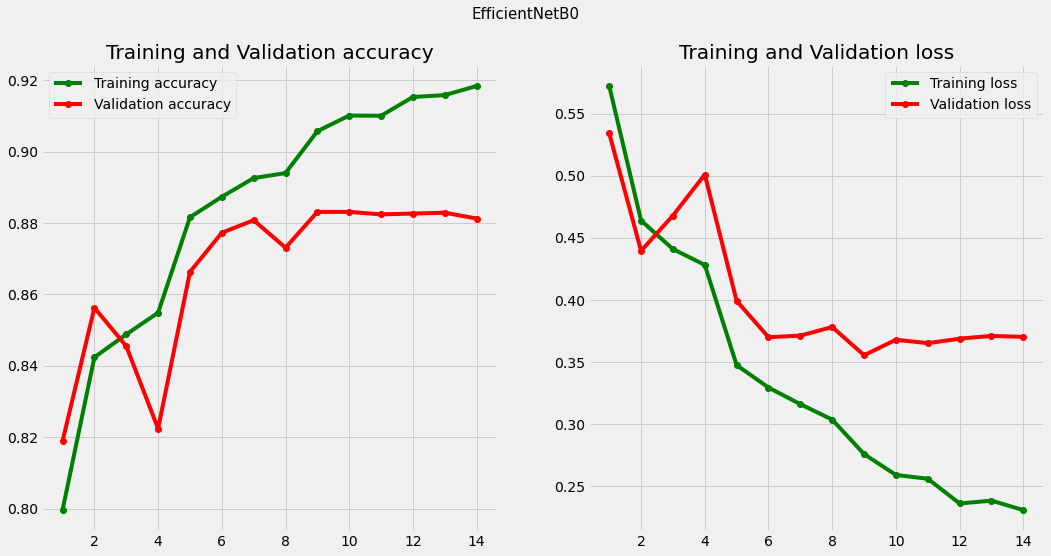

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, early_stop.stopped_epoch + 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
plt.suptitle('EfficientNetB0', size = 15)

ax1.plot(epochs, history.history['acc'], 'go-', label = 'Training accuracy')
ax1.plot(epochs, history.history['val_acc'], 'ro-', label = 'Validation accuracy')
ax1.set_title('Training and Validation accuracy')
ax1.legend()

ax2.plot(epochs, history.history['loss'], 'go-', label = 'Training loss')
ax2.plot(epochs, history.history['val_loss'], "ro-", label = 'Validation loss')
ax2.set_title('Training and Validation loss')
ax2.legend()

plt.show()

In [22]:
model.save('./EffNetB0_512_16.h5')

In [23]:
print('Training accuracy:', acc)
print('Validation accuracy:', val_acc)

print('Training loss:', loss)
print('Validation loss:', val_loss)

Training accuracy: [0.799567699432373, 0.8423881530761719, 0.8488141298294067, 0.8548895716667175, 0.8816450238227844, 0.8873699903488159, 0.8926276564598083, 0.8940296769142151, 0.9057716727256775, 0.9101530313491821, 0.9100946187973022, 0.9153522849082947, 0.9158779978752136, 0.9184483885765076]
Validation accuracy: [0.818882942199707, 0.8562748432159424, 0.8455246686935425, 0.8223884105682373, 0.8663238883018494, 0.8773077726364136, 0.8808133006095886, 0.8731011748313904, 0.8831502795219421, 0.8831502795219421, 0.8824491500854492, 0.8826828598976135, 0.8829165697097778, 0.8812806606292725]
Training loss: [0.5724680423736572, 0.4639918804168701, 0.44102194905281067, 0.4282425045967102, 0.3474867045879364, 0.32941460609436035, 0.3160349726676941, 0.30355605483055115, 0.27579063177108765, 0.2589913606643677, 0.2559310495853424, 0.2360033541917801, 0.238289013504982, 0.23066829144954681]
Validation loss: [0.5343244671821594, 0.4395929276943207, 0.46801984310150146, 0.5010585188865662, 0

## Prediction

In [24]:
submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
submission

image_id  label
0  2216849948.jpg      4

In [25]:
pred = []

for image_id in submission.image_id:
    image = Image.open(os.path.join(directory, 'test_images', image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    pred.append(np.argmax(model.predict(image)))

submission['label'] = pred
submission

image_id  label
0  2216849948.jpg      4

In [26]:
submission.to_csv('submission.csv', index = False)